# **Data Generation and Import**

# Imports & Google Drive Connect

In [ ]:
import json

In [ ]:
# pip install tensorflow
# pip install matplotlib
!pip install olga
!pip install sonia 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.4/366.4 kB 7.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.7 MB/s eta 0:00:00
  Created wheel for sonia: filename=sonia-0.1.3-py3-none-any.whl size=854648 sha256=5d653c606198a06deead6826a3eec63d255d5529be5bc34e5461722515f3c14d
  Stored in directory: /root/.cache/pip/wheels/91/f8/c5/0d24f4fcbb6fa1d7eeb6c15f295fcc7212f301ceaed48d5d0c
Successfully built sonia
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
from pathlib import Path
from os import listdir
import matplotlib.pyplot as plt
import random
import sonia
from sonia.sonia_leftpos_rightpos import SoniaLeftposRightpos
from sonia.plotting import Plotter
from sonia.evaluate_model import EvaluateModel
from sonia.sequence_generation import SequenceGeneration
import olga

from google.colab import drive

In [ ]:
# to get the data
drive.mount('/content/drive')
# drive.mount(PATH)

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
PATH = "/content/drive/MyDrive/Data Science/Thesis/SONIA_data"
os.chdir(PATH)

In [ ]:
pwd

'/content/drive/MyDrive/Data Science/Thesis/SONIA_data'

# TCRdb Data

TCRdb project: http://bioinfo.life.hust.edu.cn/TCRdb/#/display/project/PRJNA390125

TCRdb: http://bioinfo.life.hust.edu.cn/TCRdb/#/dataset

In [ ]:
PATH_tcr = '/content/drive/MyDrive/Data Science/Thesis/Data/TCRdb_project1'

In [ ]:
all_tcr_files = Path(PATH_tcr).glob('*.tsv')

l = []

for f in all_tcr_files:
    df_tcr = pd.read_csv(f, sep='\t')
    df_tcr = df_tcr.reset_index()
    new_header = df_tcr.iloc[0]
    df_tcr = df_tcr[1:]
    df_tcr.columns = new_header
    # df['cloneFraction'] = df['cloneFraction'].astype(float)
    df_tcr['sample'] = f.stem
    l.append(df_tcr)

df_full_tcr = pd.concat(l, axis=0, ignore_index=True)
df_full_tcr['cloneFraction'] = df_full_tcr['cloneFraction'].astype(float)

In [ ]:
df_full_tcr.head()

,AASeq,Vregion,Dregion,Jregion,cloneFraction,sample
0,CASRYLSRGGIPDRVNTEAFF,TRBV12-3,Unknown,TRBJ1-1,0.008281,SRR5676665
1,CSADRGTEAFF,TRBV29-1,Unknown,TRBJ1-1,0.006169,SRR5676665
2,CAWTLDSNQPQHF,TRBV30,Unknown,TRBJ1-5,0.003568,SRR5676665
3,CSGLTDTQYF,TRBV29-1,Unknown,TRBJ2-3,0.003455,SRR5676665
4,CSVGQPAAQYF,TRBV29-1,Unknown,TRBJ2-5,0.003340,SRR5676665


In [ ]:
df_full_tcr.shape

(165400, 6)

In [ ]:
df_tcr = df_full_tcr.copy()
df_tcr = df_tcr.drop(columns = ['Vregion', 'Dregion', 'Jregion'])
df_tcr.head()

,AASeq,cloneFraction,sample
0,CASRYLSRGGIPDRVNTEAFF,0.008281,SRR5676665
1,CSADRGTEAFF,0.006169,SRR5676665
2,CAWTLDSNQPQHF,0.003568,SRR5676665
3,CSGLTDTQYF,0.003455,SRR5676665
4,CSVGQPAAQYF,0.003340,SRR5676665


In [ ]:
df_tcr['cloneFraction'].min(), df_tcr['cloneFraction'].max(), df_tcr['cloneFraction'].median(), df_tcr['cloneFraction'].mean()

(1.25e-06, 0.34549896, 6.698e-05, 0.00013293194945586457)

In [ ]:
len(df_tcr[df_tcr['cloneFraction']< (1.26e-06)])

327

In [ ]:
# I'm going to multiply all of the clone fractions by 1,000,000
1.25e-6 * 1000000

1.25

In [ ]:
len(np.unique(df_tcr['AASeq']))

142770

In [ ]:
df_tcr['size'] = (df_tcr['cloneFraction']*1000000).astype(int)
df_tcr.head()

,AASeq,cloneFraction,sample,size
0,CASRYLSRGGIPDRVNTEAFF,0.008281,SRR5676665,8280
1,CSADRGTEAFF,0.006169,SRR5676665,6168
2,CAWTLDSNQPQHF,0.003568,SRR5676665,3567
3,CSGLTDTQYF,0.003455,SRR5676665,3455
4,CSVGQPAAQYF,0.003340,SRR5676665,3340


In [ ]:
df_tcr.to_csv('df_tcr', index=False)

# Sonia Data

In [ ]:
# load default model (human TRB)
model_dir=os.path.join(os.path.dirname(sonia.sonia_leftpos_rightpos.__file__),'default_models','human_T_beta')
qm=SoniaLeftposRightpos(load_dir=model_dir,chain_type='human_T_beta')

Cannot find data_seqs.tsv  --  no data seqs loaded.
Cannot find gen_seqs.tsv  --  no generated seqs loaded.


In [ ]:
# load evaluation and generation classes
ev=EvaluateModel(sonia_model=qm)
sq=SequenceGeneration(sonia_model=qm)

In [ ]:
def generate_humans_sonia(sample_size, num_humans):
  list_sonia = []

  # create new df for each human
  for h in range(num_humans):
    # generate seqs pre
    # seqs_pre=sq.generate_sequences_pre(int(sample_size)) # 10000
    
    # generate seqs post
    seqs_post = sq.generate_sequences_post(int(sample_size))

    df = pd.DataFrame(seqs_post, columns = ['AASeq','V','J', 'fullSeq'])
    list_sonia.append(df)
  
  return list_sonia

### Function

#### 10e4 sample points, 1000 humans

In [ ]:
def sample_fifty(file_name, size=10e4, humans=50):
  sample = generate_humans_sonia(size, humans)
  pd.concat(sample).to_csv(file_name, index=False)
  return sample

In [ ]:
file_names = ['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9',
              'df10', 'df11', 'df12', 'df13', 'df14', 'df15', 'df16', 'df17',
              'df18', 'df19', 'df20']
for f in file_names:
  sample_fifty(f)

34375/34375 [==============================] - 34s 997us/step


#### 10e2 sample points, 1000 humans

In [ ]:
def sample_fifty_2(file_name, size=10e2, humans=50):
  sample = generate_humans_sonia(size, humans)
  pd.concat(sample).to_csv(file_name, index=False)
  return sample

In [ ]:
file_names_2 = ['df1_2', 'df2_2', 'df3_2', 'df4_2', 'df5_2', 'df6_2', 'df7_2',
                'df8_2', 'df9_2', 'df10_2', 'df11_2', 'df12_2', 'df13_2',
                'df14_2', 'df15_2', 'df16_2', 'df17_2', 'df18_2', 'df19_2',
                'df20_2']
for f2 in file_names_2:
  sample_fifty_2(f2)


In [ ]:
def pd_to_list(df):
  df_list = []
  df_list.append(df.iloc[:100000,:])
  df_list.append(df.iloc[100000:200000,:])
  df_list.append(df.iloc[200000:300000,:])
  df_list.append(df.iloc[300000:400000,:])
  df_list.append(df.iloc[400000:500000,:])
  df_list.append(df.iloc[500000:600000,:])
  df_list.append(df.iloc[600000:700000,:])
  df_list.append(df.iloc[700000:800000,:])
  df_list.append(df.iloc[800000:900000,:])
  df_list.append(df.iloc[900000:1000000,:])
  df_list.append(df.iloc[1000000:1100000,:])
  df_list.append(df.iloc[1100000:1200000,:])
  df_list.append(df.iloc[1200000:1300000,:])
  df_list.append(df.iloc[1300000:1400000,:])
  df_list.append(df.iloc[1400000:1500000,:])
  df_list.append(df.iloc[1500000:1600000,:])
  df_list.append(df.iloc[1600000:1700000,:])
  df_list.append(df.iloc[1700000:1800000,:])
  df_list.append(df.iloc[1800000:1900000,:])
  df_list.append(df.iloc[1900000:2000000,:])
  df_list.append(df.iloc[2000000:2100000,:])
  df_list.append(df.iloc[2100000:2200000,:])
  df_list.append(df.iloc[2200000:2300000,:])
  return df_list

# Uniform Data

## Species Richness = 100,000

In [ ]:
# Random uniform distrubtion between 1 and 100, size = 100000, ... 100,000 species in the population
# Each number generated represents the number of species of that clonotype 

uniform_population = np.around(np.random.uniform(1, 100, size=100000), 0)
print(max(uniform_population))
print(min(uniform_population))

100.0
1.0


In [ ]:
print(sum(uniform_population))
print(len(uniform_population))

5037134.0
100000


In [ ]:
species_names = []
s = 'species'
for i in range(len(uniform_population)):
  species_names.append(f'{s}{i}')

In [ ]:
unif_pop_df = pd.DataFrame()
unif_pop_df['AASeq'] = species_names
unif_pop_df['size'] = (uniform_population).astype(int)
unif_pop_df.head()

,AASeq,size
0,species0,49
1,species1,31
2,species2,94
3,species3,61
4,species4,54


In [ ]:
full_unif_pop = np.repeat(unif_pop_df['AASeq'].values, unif_pop_df['size'].values)
full_unif_pop

array(['species0', 'species0', 'species0', ..., 'species99999',
       'species99999', 'species99999'], dtype=object)

In [ ]:
len(full_unif_pop)

5037134

In [ ]:
# Sampling from population
s10_000 = np.random.choice(full_unif_pop, 10000, replace=False)
s100_000 = np.random.choice(full_unif_pop, 100000, replace=False)
s1_000_000 = np.random.choice(full_unif_pop, 1000000, replace=False)
s3_000_000 = np.random.choice(full_unif_pop, 3000000, replace=False)

In [ ]:
unif_s10_000 = pd.DataFrame()
unif_s10_000['AASeq'] = s10_000
unif_s10_000['size'] = 1
print(unif_s10_000.head())
print('max count: ', max(unif_s10_000['AASeq'].value_counts()))

unif_s100_000 = pd.DataFrame()
unif_s100_000['AASeq'] = s100_000
unif_s100_000['size'] = 1
print(unif_s100_000.head())
print('max count: ', max(unif_s100_000['AASeq'].value_counts()))

unif_s1_000_000 = pd.DataFrame()
unif_s1_000_000['AASeq'] = s1_000_000
unif_s1_000_000['size'] = 1
print(unif_s1_000_000.head())
print('max count: ', max(unif_s1_000_000['AASeq'].value_counts()))

unif_s3_000_000 = pd.DataFrame()
unif_s3_000_000['AASeq'] = s3_000_000
unif_s3_000_000['size'] = 1
print(unif_s3_000_000.head())
print('max count: ', max(unif_s3_000_000['AASeq'].value_counts()))

          AASeq  size
0  species71909     1
1  species36510     1
2  species67991     1
3  species16095     1
4    species732     1
max count:  4
          AASeq  size
0  species74246     1
1  species52840     1
2  species46869     1
3  species19429     1
4   species2255     1
max count:  9
          AASeq  size
0  species76837     1
1  species60499     1
2  species86804     1
3  species79042     1
4  species33664     1
max count:  34
          AASeq  size
0  species88622     1
1  species40616     1
2  species87032     1
3  species26381     1
4  species95469     1
max count:  74


In [ ]:
# Saving all df's
unif_pop_df.to_csv('unif_pop_df.csv', index=False)
unif_s10_000.to_csv('unif_s10_000.tsv', index=False)
unif_s100_000.to_csv('unif_s100_000.tsv', index=False)
unif_s1_000_000.to_csv('unif_s1_000_000.tsv', index=False)
unif_s3_000_000.to_csv('unif_s3_000_000.tsv', index=False)

## Species Richness = 1,000,000

In [ ]:
# Random uniform distrubtion between 1 and 100, size = 100000, ... 100,000 species in the population
# Each number generated represents the number of species of that clonotype 

uniform_population_1 = np.around(np.random.uniform(1, 100, size=1000000), 0)
print(max(uniform_population_1))
print(min(uniform_population_1))
print(sum(uniform_population_1))
print(len(uniform_population_1))

100.0
1.0
50485039.0
1000000


In [ ]:
species_names = []
s = 'species'
for i in range(len(uniform_population_1)):
  species_names.append(f'{s}{i}')

In [ ]:
unif_pop_df_1 = pd.DataFrame()
unif_pop_df_1['AASeq'] = species_names
unif_pop_df_1['size'] = (uniform_population_1).astype(int)
unif_pop_df_1.head()

,AASeq,size
0,species0,16
1,species1,98
2,species2,22
3,species3,31
4,species4,84


In [ ]:
full_unif_pop_1 = np.repeat(unif_pop_df_1['AASeq'].values, unif_pop_df_1['size'].values)
print(len(full_unif_pop_1))
full_unif_pop_1

50485039


array(['species0', 'species0', 'species0', ..., 'species999999',
       'species999999', 'species999999'], dtype=object)

In [ ]:
# Sampling from population
s10_000_1 = np.random.choice(full_unif_pop_1, 10000, replace=False)
s100_000_1 = np.random.choice(full_unif_pop_1, 100000, replace=False)
s1_000_000_1 = np.random.choice(full_unif_pop_1, 1000000, replace=False)
s3_000_000_1 = np.random.choice(full_unif_pop_1, 3000000, replace=False)
s10_000_000_1 = np.random.choice(full_unif_pop_1, 10000000, replace=False)
s20_000_000_1 = np.random.choice(full_unif_pop_1, 20000000, replace=False)
s30_000_000_1 = np.random.choice(full_unif_pop_1, 30000000, replace=False)
s40_000_000_1 = np.random.choice(full_unif_pop_1, 40000000, replace=False)

In [ ]:
unif_s10_000_1 = pd.DataFrame()
unif_s10_000_1['AASeq'] = s10_000_1
unif_s10_000_1['size'] = 1
print(unif_s10_000_1.head())
print('max count: ', max(unif_s10_000_1['AASeq'].value_counts()))

unif_s100_000_1 = pd.DataFrame()
unif_s100_000_1['AASeq'] = s100_000_1
unif_s100_000_1['size'] = 1
print(unif_s100_000_1.head())
print('max count: ', max(unif_s100_000_1['AASeq'].value_counts()))

unif_s1_000_000_1 = pd.DataFrame()
unif_s1_000_000_1['AASeq'] = s1_000_000_1
unif_s1_000_000_1['size'] = 1
print(unif_s1_000_000_1.head())
print('max count: ', max(unif_s1_000_000_1['AASeq'].value_counts()))

unif_s3_000_000_1 = pd.DataFrame()
unif_s3_000_000_1['AASeq'] = s3_000_000_1
unif_s3_000_000_1['size'] = 1
print(unif_s3_000_000_1.head())
print('max count: ', max(unif_s3_000_000_1['AASeq'].value_counts()))

unif_s10_000_000_1 = pd.DataFrame()
unif_s10_000_000_1['AASeq'] = s10_000_000_1
unif_s10_000_000_1['size'] = 1
print(unif_s10_000_000_1.head())
print('max count: ', max(unif_s10_000_000_1['AASeq'].value_counts()))

unif_s20_000_000_1 = pd.DataFrame()
unif_s20_000_000_1['AASeq'] = s20_000_000_1
unif_s20_000_000_1['size'] = 1
print(unif_s20_000_000_1.head())
print('max count: ', max(unif_s20_000_000_1['AASeq'].value_counts()))

unif_s30_000_000_1 = pd.DataFrame()
unif_s30_000_000_1['AASeq'] = s30_000_000_1
unif_s30_000_000_1['size'] = 1
print(unif_s30_000_000_1.head())
print('max count: ', max(unif_s30_000_000_1['AASeq'].value_counts()))

unif_s40_000_000_1 = pd.DataFrame()
unif_s40_000_000_1['AASeq'] = s40_000_000_1
unif_s40_000_000_1['size'] = 1
print(unif_s40_000_000_1.head())
print('max count: ', max(unif_s40_000_000_1['AASeq'].value_counts()))

           AASeq  size
0  species311214     1
1  species621207     1
2  species963479     1
3  species101885     1
4  species993462     1
max count:  2
           AASeq  size
0  species186574     1
1  species699274     1
2  species678898     1
3  species998821     1
4  species122740     1
max count:  4
           AASeq  size
0  species420324     1
1  species483409     1
2  species410617     1
3  species842020     1
4  species136550     1
max count:  11
           AASeq  size
0  species130909     1
1  species205686     1
2  species698252     1
3  species270164     1
4  species745448     1
max count:  19
           AASeq  size
0  species500009     1
1  species776107     1
2  species671889     1
3  species158816     1
4  species136716     1
max count:  36
           AASeq  size
0  species283124     1
1  species946963     1
2  species835855     1
3  species617756     1
4  species188201     1
max count:  59
           AASeq  size
0  species984321     1
1  species799475     1
2   species6511

In [ ]:
# Saving all df's
unif_pop_df_1.to_csv('unif_pop_df_1.csv', index=False)
unif_s10_000_1.to_csv('unif_s10_000_1.tsv', index=False)
unif_s100_000_1.to_csv('unif_s100_000_1.tsv', index=False)
unif_s1_000_000_1.to_csv('unif_s1_000_000_1.tsv', index=False)
unif_s3_000_000_1.to_csv('unif_s3_000_000_1.tsv', index=False)
unif_s10_000_000_1.to_csv('unif_s10_000_000_1.tsv', index=False)
unif_s20_000_000_1.to_csv('unif_s20_000_000_1.tsv', index=False)
unif_s30_000_000_1.to_csv('unif_s30_000_000_1.tsv', index=False)
unif_s40_000_000_1.to_csv('unif_s40_000_000_1.tsv', index=False)

# Mixed Poisson Distribution

In [ ]:
# Define a function to generate random samples from the mixed Poisson distribution
def mixed_poisson_sample(weights, means, size):
    """
    Generate random samples from a mixed Poisson distribution.
    
    Parameters:
        weights (list): A list of weights of the component Poisson distributions.
        means (list): A list of means of the component Poisson distributions.
        size (int): The number of samples to generate.
    
    Returns:
        A numpy array of size `size` containing the generated samples.
    """
    # Normalize the weights to sum to one
    weights = np.array(weights) / sum(weights)
    
    # Generate random samples from the component Poisson distributions
    sample = np.zeros(size)
    for i in range(len(weights)):
        sample += np.random.poisson(means[i], size) * weights[i]
    
    return sample

## Species Richness = 100,000

Sample mean: 4.098943
Sample variance: 1.8141373827510001
Sample histogram:


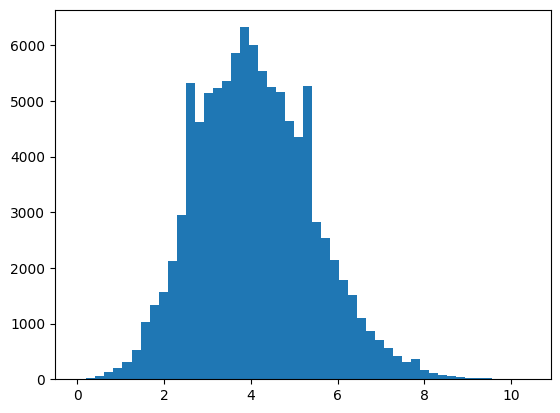

In [ ]:
# Define the parameters of the mixed Poisson distribution
weights = [0.2, 0.3, 0.5]  # weights of the component Poisson distributions
means = [1, 3, 6]  # means of the component Poisson distributions

# Generate 10,000 random samples from the mixed Poisson distribution
sample = mixed_poisson_sample(weights, means, 100000)

# Print some summary statistics of the generated sample
print("Sample mean:", np.mean(sample))
print("Sample variance:", np.var(sample))
print("Sample histogram:")
_ = plt.hist(sample, bins=50)


In [ ]:
species_names = []
s = 'species'
for i in range(len(sample)):
  species_names.append(f'{s}{i}')

In [ ]:
mixedp_df = pd.DataFrame()
mixedp_df['AASeq'] = species_names
mixedp_df['size'] = (sample).astype(int)
mixedp_df.head()

,AASeq,size
0,species0,4
1,species1,6
2,species2,3
3,species3,2
4,species4,4


In [ ]:
full_mixedp_pop = np.repeat(mixedp_df['AASeq'].values, mixedp_df['size'].values)
full_mixedp_pop

array(['species0', 'species0', 'species0', ..., 'species99999',
       'species99999', 'species99999'], dtype=object)

In [ ]:
len(full_mixedp_pop)

364902

In [ ]:
# Sampling from population
mp10_000 = np.random.choice(full_mixedp_pop, 10000, replace=False)
mp100_000 = np.random.choice(full_mixedp_pop, 100000, replace=False)
mp300_000 = np.random.choice(full_mixedp_pop, 300000, replace=False)

# mp1_000_000 = np.random.choice(full_mixedp_pop, 1000000, replace=False)
# mp3_000_000 = np.random.choice(full_mixedp_pop, 3000000, replace=False)

In [ ]:
mp_10000 = pd.DataFrame()
mp_10000['AASeq'] = mp10_000
mp_10000['size'] = 1
print(mp_10000.head())
print('max count: ', max(mp_10000['AASeq'].value_counts()))

mp_100000 = pd.DataFrame()
mp_100000['AASeq'] = mp100_000
mp_100000['size'] = 1
print(mp_100000.head())
print('max count: ', max(mp_100000['AASeq'].value_counts()))

mp_300000 = pd.DataFrame()
mp_300000['AASeq'] = mp300_000
mp_300000['size'] = 1
print(mp_300000.head())
print('max count: ', max(mp_300000['AASeq'].value_counts()))

          AASeq  size
0  species36958     1
1  species14851     1
2  species69997     1
3  species51576     1
4  species97423     1
max count:  3
          AASeq  size
0  species12447     1
1  species21074     1
2  species47559     1
3  species76659     1
4   species2406     1
max count:  7
          AASeq  size
0   species1128     1
1  species57016     1
2  species47016     1
3  species92635     1
4  species86926     1
max count:  10


In [ ]:
mp_10000.to_csv('mp_10000.tsv', index=False)
mp_100000.to_csv('mp_100000.tsv', index=False)
mp_300000.to_csv('mp_300000.tsv', index=False)


## Species Richenss = 1,000,000

Sample mean: 4.100682399999999
Sample variance: 1.8068418343302408
Sample histogram:


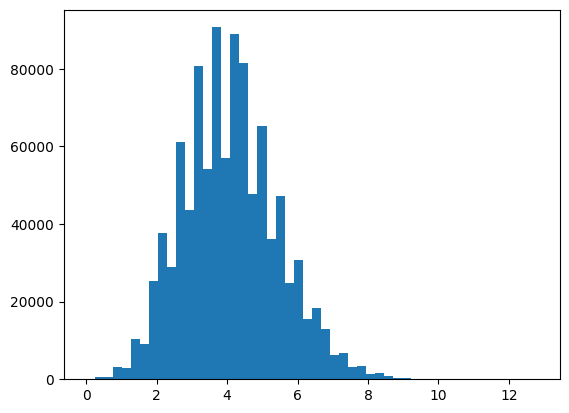

In [ ]:
# Define the parameters of the mixed Poisson distribution
weights = [0.2, 0.3, 0.5]  # weights of the component Poisson distributions
means = [1, 3, 6]  # means of the component Poisson distributions

# Generate 10,000 random samples from the mixed Poisson distribution
sample = mixed_poisson_sample(weights, means, 1000000)

# Print some summary statistics of the generated sample
print("Sample mean:", np.mean(sample))
print("Sample variance:", np.var(sample))
print("Sample histogram:")
_ = plt.hist(sample, bins=50)


In [ ]:
species_names = []
s = 'species'
for i in range(len(sample)):
  species_names.append(f'{s}{i}')

In [ ]:
mixedp_df_1 = pd.DataFrame()
mixedp_df_1['AASeq'] = species_names
mixedp_df_1['size'] = (sample).astype(int)
mixedp_df_1.head()

,AASeq,size
0,species0,3
1,species1,4
2,species2,2
3,species3,6
4,species4,4


In [ ]:
full_mixedp_pop_1 = np.repeat(mixedp_df_1['AASeq'].values, mixedp_df_1['size'].values)
print(len(full_mixedp_pop_1))
full_mixedp_pop_1

3650542


array(['species0', 'species0', 'species0', ..., 'species999999',
       'species999999', 'species999999'], dtype=object)

In [ ]:
# Sampling from population
mp10_000_1 = np.random.choice(full_mixedp_pop_1, 10000, replace=False)
mp100_000_1 = np.random.choice(full_mixedp_pop_1, 100000, replace=False)
mp300_000_1 = np.random.choice(full_mixedp_pop_1, 300000, replace=False)
mp1_000_000_1 = np.random.choice(full_mixedp_pop_1, 1000000, replace=False)
mp2_000_000_1 = np.random.choice(full_mixedp_pop_1, 2000000, replace=False)


# mp1_000_000_1 = np.random.choice(full_mixedp_pop_1, 1000000, replace=False)
# mp3_000_000_1 = np.random.choice(full_mixedp_pop_1, 3000000, replace=False)

In [ ]:
mp_10000_1 = pd.DataFrame()
mp_10000_1['AASeq'] = mp10_000_1
mp_10000_1['size'] = 1
print(mp_10000_1.head())
print('max count: ', max(mp_10000_1['AASeq'].value_counts()))

mp_100000_1 = pd.DataFrame()
mp_100000_1['AASeq'] = mp100_000_1
mp_100000_1['size'] = 1
print(mp_100000_1.head())
print('max count: ', max(mp_100000_1['AASeq'].value_counts()))

mp_300000_1 = pd.DataFrame()
mp_300000_1['AASeq'] = mp300_000_1
mp_300000_1['size'] = 1
print(mp_300000_1.head())
print('max count: ', max(mp_300000_1['AASeq'].value_counts()))

mp_1000000_1 = pd.DataFrame()
mp_1000000_1['AASeq'] = mp1_000_000_1
mp_1000000_1['size'] = 1
print(mp_1000000_1.head())
print('max count: ', max(mp_1000000_1['AASeq'].value_counts()))

mp_2000000_1 = pd.DataFrame()
mp_2000000_1['AASeq'] = mp2_000_000_1
mp_2000000_1['size'] = 1
print(mp_2000000_1.head())
print('max count: ', max(mp_2000000_1['AASeq'].value_counts()))

           AASeq  size
0  species912441     1
1  species853564     1
2  species438918     1
3  species215377     1
4  species103679     1
max count:  3
           AASeq  size
0  species131412     1
1  species994312     1
2  species469158     1
3  species205020     1
4  species285176     1
max count:  4
           AASeq  size
0  species449457     1
1  species613761     1
2  species984528     1
3  species717954     1
4  species331640     1
max count:  5
           AASeq  size
0  species401940     1
1  species974555     1
2  species337182     1
3  species717517     1
4  species231104     1
max count:  7
           AASeq  size
0  species895607     1
1   species63835     1
2  species652537     1
3  species973006     1
4  species848732     1
max count:  9


In [ ]:
mp_10000_1.to_csv('mp_10000_1.tsv', index=False)
mp_100000_1.to_csv('mp_100000_1.tsv', index=False)
mp_300000_1.to_csv('mp_300000_1.tsv', index=False)
mp_1000000_1.to_csv('mp_1000000_1.tsv', index=False)
mp_2000000_1.to_csv('mp_2000000_1.tsv', index=False)